<a href="https://colab.research.google.com/github/crissipires/tcc/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import json

from google.colab import drive
from wordcloud import WordCloud
from nltk.stem import RSLPStemmer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
!pip install spacy==3.7.2

!pip install https://github.com/explosion/spacy-models/releases/download/pt_core_news_lg-3.7.0/pt_core_news_lg-3.7.0-py3-none-any.whl

# 4️⃣ Importa e testa
import spacy
nltk.download('rslp')

#python -m spacy download pt_core_news_lg

drive.mount('/content/drive')

nltk.download('vader_lexicon')
nltk.download('punkt_tab')
nltk.download('stopwords')

nlp = spacy.load("pt_core_news_lg")







     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 1.0 MB/s eta 0:00:00


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv("drive/MyDrive/TCC/comentarios_total.csv")
df = df.dropna(subset=['comentario'])
comentarios = df['comentario'].tolist()
import re
import spacy

stopwords_pt = nltk.corpus.stopwords.words('portuguese')
stopwords = set(stopwords_pt)
stopwords.discard('não')

def preprocessar(texto):
        tokens_processados = []
        texto = re.sub(r'\b\d{1,2}/\d{1,2}/\d{4}\b', '', texto)     # datas
        texto = re.sub(r'\b\d{2,4}-\d{6,9}\b', '', texto)
        texto = re.sub(r'http\S+', '', texto)
        texto = re.sub(r'\b\d{2,4}-\d{6,9}\b', '', texto)
        texto = re.sub(r'\d+', '', texto)
        texto = re.sub(r'(.)\1{2,}', r'\1', texto)           # números tipo CPF/CNPJ
        texto = re.sub(r'\d+', '', texto)                           # números
        texto = re.sub(r'[^a-zA-ZáàâãéèêíïóôõöúçÁÀÂÃÉÈÊÍÏÓÔÕÖÚÇ\s]', '', texto)  # não letras
        texto = re.sub(r'\b(\w)\1{2,}\b', '', texto)


        doc = nlp(texto)
        for token in doc:
            t = token.text.lower()
            if not token.is_punct and not token.like_num and t not in stopwords_pt and len(t) > 1:
                lemma = token.lemma_.lower()
                tokens_processados.append(lemma)
        return tokens_processados

tokens_comentariosss = [preprocessar(c) for c in comentarios]
for i, tokens in enumerate(tokens_comentariosss):
    print(f"Comentário {i+1}: {comentarios[i]}")
    print(f"Tokens processados: {tokens}")
    print("------")


A saída de streaming foi truncada nas últimas 5000 linhas.
Tokens processados: ['ainda', 'esperar', 'produto', 'ainda', 'fé', 'receber', 'esperar', 'bom', 'vontade', 'correio']
------
Comentário 47280: O refletor é bom, atendeu perfeitamente minha necessidade. Recomendo
Tokens processados: ['refletor', 'bom', 'atender', 'perfeitamente', 'necessidade', 'recomendo']
------
Comentário 47281: Bom custo/benefício, atende minhas necessidades, boa qualidade de fotos e vídeos.
Tokens processados: ['bom', 'custobenefício', 'atender', 'necessidade', 'bom', 'qualidade', 'foto', 'vídeo']
------
Comentário 47282: Tudo correu bem com o produto e entrega. Entrega dentro do prazo e produto conforme descrição e imagem do site
Tokens processados: ['tudo', 'correr', 'bem', 'produto', 'entregar', 'entrega', 'dentro', 'prazo', 'produto', 'conforme', 'descrição', 'imagem', 'site']
------
Comentário 47283: Somente aparelhos usados não são entregues? Por que quando são produtos novos há disponibilidade de ent

In [ ]:
def carregar_oplexicon(caminho_arquivo):
    lexico = {}
    with open(caminho_arquivo, "r", encoding="utf-8") as f:
        for linha in f:
            linha = linha.strip()
            if not linha or linha.startswith("#"):
                continue

            try:
                partes = linha.split(",")
                palavra = partes[0].lower()
                polaridade = int(partes[2])
                lexico[palavra] = polaridade
            except:
                continue
    return lexico



caminho = "drive/MyDrive/TCC/lexico_v3.0.txt"
lexicoOpLexicon = carregar_oplexicon(caminho)


In [ ]:
def carregar_unilex(caminho_arquivo):
    lexico = {}
    with open(caminho_arquivo, "r", encoding="utf-8") as f:
        for linha in f:
            linha = linha.strip()

            if not linha or linha.startswith("#"):
                continue

            try:
                partes = [p.strip() for p in linha.replace("\t", ",").split(",") if p.strip()]
                palavra = partes[0].strip().lower()
                polaridade = int(partes[1].strip())
                lexico[palavra] = polaridade
            except:
                continue
    return lexico


# Exemplo de uso:
caminho_unilex = "drive/MyDrive/TCC/unilex-TF-IDF.txt"
lexicoUnilex = carregar_unilex(caminho_unilex)
print(lexicoUnilex)


{'abaixando': -1, 'abaixo': 2, 'abismo': -1, 'aborda': 1, 'abrandamento': 1, 'abril': -1, 'abrir': 2, 'absoluto': -2, 'absurdo': -4, 'abusivo': -1, 'acaba': 1, 'acabar': -1, 'acabou': -4, 'acao': 1, 'aceio': 1, 'aceitara': 1, 'aceitaram': 1, 'aceite': -1, 'acertam': 1, 'acertar': 1, 'acertos': 1, 'acesse': 1, 'acesso': 3, 'acha': -3, 'acham': -3, 'achavam': -1, 'achei': 2, 'acho': 2, 'acimadetdudoportugal': -1, 'acimadetudoportugal': 7, 'acirgurgacz': 1, 'acoes': -1, 'acompanhe': 2, 'acontecer': -1, 'acordabrasil': -1, 'acordar': 1, 'acordastf': 1, 'acordos': 1, 'acreditado': -1, 'acreditam': -1, 'acreditar': 2, 'acredito': 2, 'acreditou': -1, 'acrescentar': 1, 'acronimo': -1, 'acucar': 1, 'acusa': -1, 'acusacoes': -1, 'acusado': -1, 'acusados': -1, 'aderir': 1, 'adesao': -1, 'adia': -1, 'administracao': -1, 'administradas': -1, 'admitiu': 1, 'adorei': 1, 'adoro': 2, 'adubo': -1, 'adv': -1, 'advogada': 1, 'advogado': 1, 'advogados': -1, 'ae': -2, 'aecim': 1, 'aecio': -7, 'aecioneves': 

In [ ]:
def carregar_sentilex(caminho_arquivo):
  sentilex = {}
  with open(caminho_arquivo, "r", encoding="UTF-8") as f:
    for linha in f:
                linha = linha.strip()
                if not linha or linha.startswith("#"):
                    continue

                try:
                    palavra =  linha.split(".")[0].lower()
                    pols = []
                    for attr in linha.split(";"):
                        if attr.startswith("POL"):
                            valor = int(attr.split("=")[1])
                            pols.append(valor)

                    if pols:
                        sentilex[palavra] = sum(pols)
                except:
                    continue
  return sentilex

lexicoSentilex = carregar_sentilex("drive/MyDrive/TCC/SentiLex-lem-PT02.txt")
#print(list(lexico.items()))


In [ ]:
def analisar_sentimento(tokens, lexico):
    score = 0
    inverter = False
    score_pos = 0
    score_neg = 0


    for token in tokens:

        if token in ["jamais", "nada", "nem", "nenhum", "ninguém", "nunca", "não", "tampouco"]:
             inverter = True
             continue

        pol = lexico.get(token, 0)
        if inverter and pol != 0:
            pol = -pol
            inverter = False

        score += pol
        if pol > 0:
            score_pos += pol
        elif pol < 0:
            score_neg += abs(pol)

    # if abs(score_pos - score_neg) < 1:
    #     return 0, score
    # elif score_pos > score_neg:
    #     return 2, score
    # else:
    #     return 1, score

    if score_neg > score_pos:
        return 1, score
    elif score_pos > score_neg:
        return 2, score
    else:
        return 0, score
    # if score > 0:
    #     return 2, score
    # elif score < 0:
    #     return 1, score
    # else:
    #    return 0, score


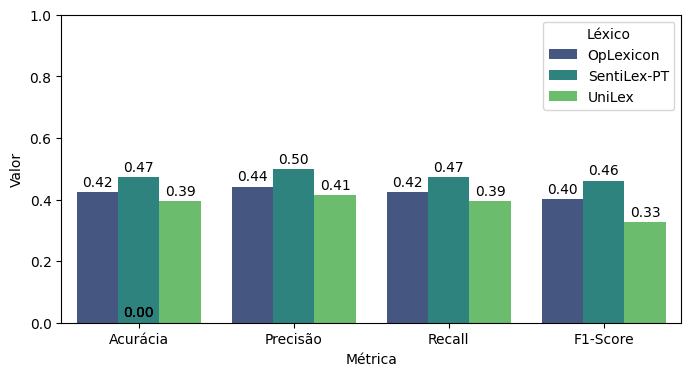

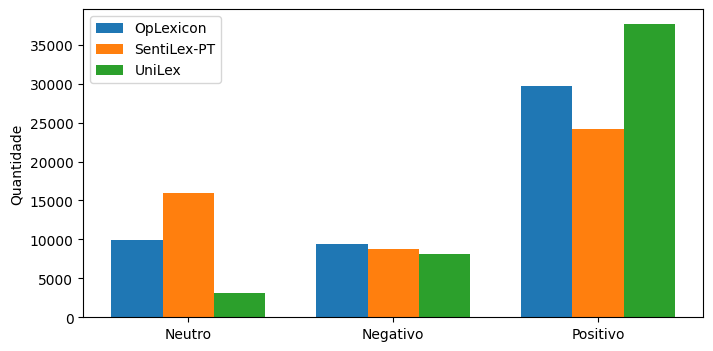

Léxico: OpLexicon
Distribuição: Counter({2: 29705, 0: 9890, 1: 9350})
------------------------------
Léxico: SentiLex-PT
Distribuição: Counter({2: 24240, 0: 15937, 1: 8768})
------------------------------
Léxico: UniLex
Distribuição: Counter({2: 37673, 1: 8154, 0: 3118})
------------------------------
[[ 3267  2385 10663]
 [ 3697  5536  7082]
 [ 2926  1429 11960]]


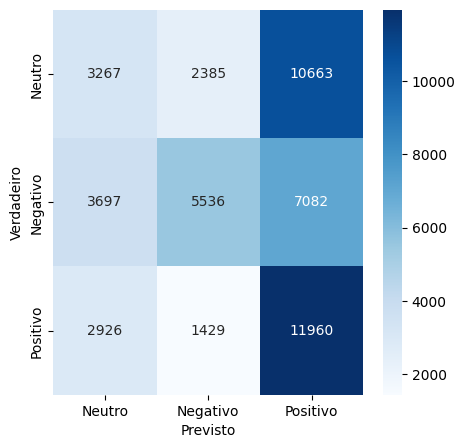

[[ 5305  2160  8850]
 [ 7026  5847  3442]
 [ 3606   761 11948]]


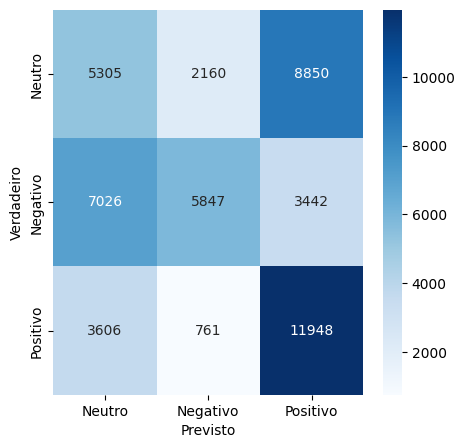

[[ 1031  2172 13112]
 [ 1171  4426 10718]
 [  916  1556 13843]]


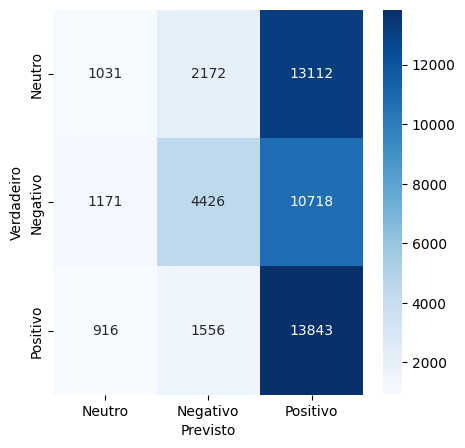

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
import pandas as pd

def avaliar_lexico(nome_lexico, comentarios, lexico, y_true):
    sentimentos = []
    for com in comentarios:
        sentimento, _ = analisar_sentimento(com, lexico)
        sentimentos.append(sentimento)

    matriz = confusion_matrix(y_true, sentimentos, labels=[0, 1, 2])
    acuracia = accuracy_score(y_true, sentimentos)
    precisao = precision_score(y_true, sentimentos, average='weighted', labels=[0, 1, 2])
    recall = recall_score(y_true, sentimentos, average='weighted', labels=[0, 1, 2])
    f1 = f1_score(y_true, sentimentos, average='weighted', labels=[0, 1, 2])

    return {
        'Lexico': nome_lexico,
        'Acuracia': acuracia,
        'Precisao': precisao,
        'Recall': recall,
        'F1-Score': f1,
        'Matriz': matriz,
        'Distribuicao': Counter(sentimentos)
    }

# ============================
# 🧪 Exemplo de uso
# ============================

# supondo que você tenha 3 dicionários carregados:
# lexico1, lexico2, lexico3
# e um DataFrame com a coluna de sentimentos verdadeiros:
y_true = df['sentimento']
comentarios = tokens_comentariosss  # lista de tokens dos comentários

resultados = []
resultados.append(avaliar_lexico("OpLexicon", comentarios, lexicoOpLexicon, y_true))
resultados.append(avaliar_lexico("SentiLex-PT", comentarios, lexicoSentilex, y_true))
resultados.append(avaliar_lexico("UniLex", comentarios, lexicoUnilex, y_true))

# ============================
# 📈 Tabelando os resultados
# ============================

df_metricas = pd.DataFrame([{
    'Léxico': r['Lexico'],
    'Acurácia': r['Acuracia'],
    'Precisão': r['Precisao'],
    'Recall': r['Recall'],
    'F1-Score': r['F1-Score']
} for r in resultados])

# ============================
# 📊 Gráfico Comparativo de Métricas
# ============================
df_metricas_melt = df_metricas.melt(id_vars='Léxico', var_name='Métrica', value_name='Valor')
plt.figure(figsize=(8,4))
sns.barplot(data=df_metricas_melt, x='Métrica', y='Valor', hue='Léxico', palette='viridis')
plt.ylim(0, 1)
plt.legend(title='Léxico')
for i, bar in enumerate(plt.gca().patches):
    plt.gca().text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.02,
        f"{bar.get_height():.2f}",
        ha='center'
    )
plt.show()

# ============================
# 📊 Gráfico de Distribuição de Sentimentos
# ============================
plt.figure(figsize=(8,4))
largura = 0.25
classes = ['Neutro', 'Negativo', 'Positivo']

for i, r in enumerate(resultados):
    dist = r['Distribuicao']
    valores = [dist.get(0), dist.get(1), dist.get(2)]
    pos = [x + i*largura for x in range(len(classes))]
    plt.bar(pos, valores, width=largura, label=r['Lexico'])

plt.xticks([r + largura for r in range(len(classes))], classes)
plt.ylabel('Quantidade')
plt.legend()
plt.show()

for r in resultados:
    print(f"Léxico: {r['Lexico']}")
    print(f"Distribuição: {r['Distribuicao']}")
    print("-" * 30)


# ============================
# 📊 Matriz de Confusão para cada Léxico
# ============================

for r in resultados:
    print(r['Matriz'])
    plt.figure(figsize=(5,5))
    sns.heatmap(r['Matriz'], annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.show()


In [ ]:
metricasOpLexicon = Metricas(tokens_comentariossss, lexicoOpLexicon)
metricasOpLexicon.Mostrar()


# Matriz de Confusão - Spacy + NLTK:
# [[106  87 307]
#  [118 173 209]
#  [ 99  40 361]]

# Acurácia: 0.4266666666666667
# Precisão: 0.43882353333419627
# Abrangência (Recall): 0.4266666666666667
# F1-Score: 0.4048074724992227

# Relatório completo:
#               precision    recall  f1-score   support

#            0       0.33      0.21      0.26       500
#            1       0.58      0.35      0.43       500
#            2       0.41      0.72      0.52       500

#     accuracy                           0.43      1500
#    macro avg       0.44      0.43      0.40      1500
# weighted avg       0.44      0.43      0.40      1500

# Matriz de Confusão - NLTK:
# [[130  92 278]
#  [163 178 159]
#  [ 87  26 387]]

# Acurácia: 0.4633333333333333
# Precisão: 0.47103893622800114
# Abrangência (Recall): 0.4633333333333333
# F1-Score: 0.4424276237913912

# Relatório completo:
#               precision    recall  f1-score   support

#            0       0.34      0.26      0.30       500
#            1       0.60      0.36      0.45       500
#            2       0.47      0.77      0.58       500

#     accuracy                           0.46      1500
#    macro avg       0.47      0.46      0.44      1500
# weighted avg       0.47      0.46      0.44      1500


# Matriz de Confusão - Spacy:
# [[142 108 250]
#  [122 177 201]
#  [106  59 335]]

# Acurácia: 0.436
# Precisão: 0.4415091063014017
# Abrangência (Recall): 0.436
# F1-Score: 0.4222877985333962

# Relatório completo:
#               precision    recall  f1-score   support

#            0       0.38      0.28      0.33       500
#            1       0.51      0.35      0.42       500
#            2       0.43      0.67      0.52       500

#     accuracy                           0.44      1500
#    macro avg       0.44      0.44      0.42      1500
# weighted avg       0.44      0.44      0.42      1500



NameError: name 'tokens_comentariossss' is not defined

In [ ]:
metricaslexicoUnilex = Metricas(tokens_comentariossss, lexicoUnilex)
metricaslexicoUnilex.Mostrar()

In [ ]:
metricasSentilex = Metricas(tokens_comentariossss, lexicoSentilex)
metricasSentilex.Mostrar()


# Matriz de Confusão - Spacy + NLTK:
# [[168  73 259]
#  [209 173 118]
#  [ 97  34 369]]

# Acurácia: 0.47333333333333333
# Precisão: 0.4889751974363574
# Abrangência (Recall): 0.47333333333333333
# F1-Score: 0.46028476262424073

# Relatório completo:
#               precision    recall  f1-score   support

#            0       0.35      0.34      0.34       500
#            1       0.62      0.35      0.44       500
#            2       0.49      0.74      0.59       500

#     accuracy                           0.47      1500
#    macro avg       0.49      0.47      0.46      1500
# weighted avg       0.49      0.47      0.46      1500


# Matriz de Confusão - NLTK:
# [[210  76 214]
#  [251 136 113]
#  [148  36 316]]

# Acurácia: 0.44133333333333336
# Precisão: 0.46155367607923325
# Abrangência (Recall): 0.44133333333333336
# F1-Score: 0.4317622714845153

# Relatório completo:
#               precision    recall  f1-score   support

#            0       0.34      0.42      0.38       500
#            1       0.55      0.27      0.36       500
#            2       0.49      0.63      0.55       500

#     accuracy                           0.44      1500
#    macro avg       0.46      0.44      0.43      1500
# weighted avg       0.46      0.44      0.43      1500


# Matriz de Confusão - Spacy:
# [[231  88 181]
#  [223 171 106]
#  [137  37 326]]

# Acurácia: 0.48533333333333334
# Precisão: 0.5001254711953944
# Abrangência (Recall): 0.48533333333333334
# F1-Score: 0.47963902848467826

# Relatório completo:
#               precision    recall  f1-score   support

#            0       0.39      0.46      0.42       500
#            1       0.58      0.34      0.43       500
#            2       0.53      0.65      0.59       500

#     accuracy                           0.49      1500
#    macro avg       0.50      0.49      0.48      1500
# weighted avg       0.50      0.49      0.48      1500

In [ ]:
stopwords_pt = nltk.corpus.stopwords.words('portuguese')
stopwords = set(stopwords_pt)
stopwords.discard('não')

class AnaliseMachineLearning:
    def __init__(self, comentarios_preprocessados, sentimentos):
        self.comentarios_preprocessados = comentarios_preprocessados
        self.sentimentos = sentimentos
        self.treinamento()

    def treinamento(self):
        # self.X_train = self.comentarios_preprocessados
        # self.y_train = self.sentimentos

        # self.X_test = tokens_comentariosTeste
        # self.y_test = sentimentosP
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.comentarios_preprocessados,
            self.sentimentos,
            test_size=0.5,
            random_state=42
        )

    def randomForest(self, tipoVetor):
        X_train_vec, X_test_vec = self.vetorizacao(tipoVetor, self.X_train, self.X_test)
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train_vec, self.y_train)
        y_pred = model.predict(X_test_vec)
        self.metricas(self.y_test, y_pred, "Random Forest")

    def svm(self, tipoVetor):
        X_train_vec, X_test_vec = self.vetorizacao(tipoVetor, self.X_train, self.X_test)
        model = LinearSVC()
        model.fit(X_train_vec, self.y_train)
        y_pred = model.predict(X_test_vec)
        self.metricas(self.y_test, y_pred, "SVM")

    def naiveBayes(self, tipoVetor):
        X_train_vec, X_test_vec = self.vetorizacao(tipoVetor, self.X_train, self.X_test)
        model = MultinomialNB()
        model.fit(X_train_vec, self.y_train)
        y_pred = model.predict(X_test_vec)
        self.metricas(self.y_test, y_pred, "Naive Bayes")

    def vetorizacao(self, tipo, X_train, X_test):
        if tipo == 0:
           vectorizer = TfidfVectorizer(stop_words=list(stopwords) , max_features=5000)
        elif tipo == 1:
            # TF IDF com unigramas e bigramas
            vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
        elif tipo == 2:
            # Bag of words
            vectorizer = CountVectorizer(ngram_range=(1,2), max_features=5000)
        elif tipo == 3:
            # Bag of words apenas com bigramas
            vectorizer = CountVectorizer(stop_words=list(stopwords), max_features=5000, ngram_range=(2,2))
        else:
            raise ValueError("Tipo de vetorização inválido. Use 1, 2 ou 3.")

        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)
        return (X_train_vec, X_test_vec)

    def metricas(self, y_test, y_pred, classificador):
        print("\n=== Relatório de classificação (" + classificador + ") ===")
        print(classification_report(y_test, y_pred))

        acuracia = accuracy_score(y_test, y_pred)
        print("Acurácia:", acuracia)

        precisao = precision_score(y_test, y_pred, average='weighted')
        print("Precisão:", precisao)

        recall = recall_score(y_test, y_pred, average='weighted')
        print("Recall:", recall)

        f1 = f1_score(y_test, y_pred, average='weighted')
        print("F1-Score:", f1)

        print("\nMatriz de confusão:")
        print(confusion_matrix(y_test, y_pred))


In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
)
import numpy as np

class AnaliseMachineLearning:
    def __init__(self, comentarios_preprocessados, sentimentos):
        self.comentarios_preprocessados = comentarios_preprocessados
        self.sentimentos = sentimentos

    def randomForest(self, tipoVetor):
        self._validacao_cruzada(RandomForestClassifier(n_estimators=100, random_state=42), tipoVetor, "Random Forest")

    def svm(self, tipoVetor):
        self._validacao_cruzada(LinearSVC(random_state=42), tipoVetor, "SVM")

    def naiveBayes(self, tipoVetor):
        self._validacao_cruzada(MultinomialNB(), tipoVetor, "Naive Bayes")

    def _validacao_cruzada(self, modelo, tipoVetor, nome_modelo):
        # Vetorização de todos os dados
        vetor = self._vetorizacao(tipoVetor)
        X_vec = vetor.fit_transform(self.comentarios_preprocessados)
        y = self.sentimentos

        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        acuracias, precisao, recall, f1 = [], [], [], []

        print(f"\n=== Validação Cruzada (5-Fold) — {nome_modelo} ===")

        for fold, (train_idx, test_idx) in enumerate(kf.split(X_vec), start=1):
            X_train, X_test = X_vec[train_idx], X_vec[test_idx]
            y_train, y_test = np.array(y)[train_idx], np.array(y)[test_idx]

            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)

            acuracias.append(accuracy_score(y_test, y_pred))
            precisao.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
            recall.append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
            f1.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))

            print(f"\nFold {fold}:")
            print(classification_report(y_test, y_pred, zero_division=0))

        print("\n=== Resultados Médios ===")
        print(f"Acurácia média: {np.mean(acuracias):.4f}")
        print(f"Precisão média: {np.mean(precisao):.4f}")
        print(f"Recall médio: {np.mean(recall):.4f}")
        print(f"F1-score médio: {np.mean(f1):.4f}")

    def _vetorizacao(self, tipo):
        if tipo == 0:
            return TfidfVectorizer(stop_words=list(stopwords), max_features=5000)
        elif tipo == 1:
            return TfidfVectorizer(ngram_range=(1,2), max_features=5000)
        elif tipo == 2:
            return CountVectorizer(ngram_range=(1,2), max_features=5000)
        elif tipo == 3:
            return CountVectorizer(stop_words=list(stopwords), max_features=5000, ngram_range=(2,2))
        else:
            raise ValueError("Tipo de vetorização inválido. Use 0, 1, 2 ou 3.")


In [ ]:
analise = AnaliseMachineLearning(comentarios_preprocessados=[" ".join(tokens) for tokens in tokens_comentario_maq], sentimentos=df["sentimento"])
analise.randomForest(3)

# === Resultados Médios 10 - 0 ===
# Acurácia média: 0.7043
# Precisão média: 0.6980
# Recall médio: 0.7043
# F1-score médio: 0.6990

In [ ]:
analise = AnaliseMachineLearning(comentarios_preprocessados=tokens_comentarioss, sentimentos=df["sentimento"])
analise.svm(0)

# === Resultados Médios 10 - 1 ===
# Acurácia média: 0.7120
# Precisão média: 0.7077
# Recall médio: 0.7120
# F1-score médio: 0.7092

In [ ]:
analise = AnaliseMachineLearning(comentarios_preprocessados=tokens_comentarioss, sentimentos=df["sentimento"])
analise.naiveBayes(2)



In [ ]:
modelo = AnaliseMachineLearning(tokens_comentario_maq, df["sentimento"])
modelo.svm(0)


# === Relatório de classificação (SVM) - TF-IDF Unigram ===
#               precision    recall  f1-score   support

#            0       0.57      0.54      0.56      4696
#            1       0.77      0.82      0.79      4796
#            2       0.71      0.71      0.71      4742

#     accuracy                           0.69     14234
#    macro avg       0.68      0.69      0.69     14234
# weighted avg       0.69      0.69      0.69     14234

# Acurácia: 0.689265139806098
# Precisão: 0.6854892084555073
# Recall: 0.689265139806098
# F1-Score: 0.6869767041966379

# Matriz de confusão:
# [[2541  948 1207]
#  [ 728 3918  150]
#  [1162  228 3352]]


# === Relatório de classificação (SVM) - TF-IDF com n-gramas===
#               precision    recall  f1-score   support

#            0       0.59      0.56      0.57      4696
#            1       0.79      0.83      0.81      4796
#            2       0.72      0.72      0.72      4742

#     accuracy                           0.70     14234
#    macro avg       0.70      0.70      0.70     14234
# weighted avg       0.70      0.70      0.70     14234

# Acurácia: 0.7042995644232121
# Precisão: 0.7004290446933075
# Recall: 0.7042995644232121
# F1-Score: 0.7019621440567793

# Matriz de confusão:
# [[2614  883 1199]
#  [ 664 3984  148]
#  [1121  194 3427]]


# === Relatório de classificação (SVM) - Bag of words ===
#               precision    recall  f1-score   support

#            0       0.56      0.53      0.54      4696
#            1       0.77      0.79      0.78      4796
#            2       0.69      0.71      0.70      4742

#     accuracy                           0.68     14234
#    macro avg       0.67      0.67      0.67     14234
# weighted avg       0.67      0.68      0.67     14234

# Acurácia: 0.6758465645637207
# Precisão: 0.6729538434209298
# Recall: 0.6758465645637207
# F1-Score: 0.6742026647704552

# Matriz de confusão:
# [[2477  914 1305]
#  [ 829 3773  194]
#  [1151  221 3370]]

In [ ]:
modelo = AnaliseMachineLearning(tokens_comentarioss, df["sentimento"])
modelo.naiveBayes(2)

# === Relatório de classificação (Naive Bayes) - TF-IDF Unigram ===
#               precision    recall  f1-score   support

#            0       0.55      0.54      0.54      4696
#            1       0.76      0.78      0.77      4796
#            2       0.72      0.73      0.72      4742

#     accuracy                           0.68     14234
#    macro avg       0.68      0.68      0.68     14234
# weighted avg       0.68      0.68      0.68     14234

# Acurácia: 0.6818884361388226
# Precisão: 0.6799817698554091
# Recall: 0.6818884361388226
# F1-Score: 0.680861685164407

# Matriz de confusão:
# [[2522  929 1245]
#  [ 973 3745   78]
#  [1068  235 3439]]


# === Relatório de classificação (Naive Bayes) - TF-IDF com n-gramas ===
#               precision    recall  f1-score   support

#            0       0.58      0.55      0.57      4696
#            1       0.78      0.81      0.79      4796
#            2       0.73      0.73      0.73      4742

#     accuracy                           0.70     14234
#    macro avg       0.70      0.70      0.70     14234
# weighted avg       0.70      0.70      0.70     14234

# Acurácia: 0.698538710130673
# Precisão: 0.6959587653623299
# Recall: 0.698538710130673
# F1-Score: 0.697080634421243

# Matriz de confusão:
# [[2603  874 1219]
#  [ 859 3880   57]
#  [1054  228 3460]]

# === Relatório de classificação (Naive Bayes) - Bag of words===
#               precision    recall  f1-score   support

#            0       0.56      0.53      0.54      4696
#            1       0.79      0.76      0.77      4796
#            2       0.71      0.77      0.74      4742

#     accuracy                           0.69     14234
#    macro avg       0.69      0.69      0.69     14234
# weighted avg       0.69      0.69      0.69     14234

# Acurácia: 0.6877195447520023
# Precisão: 0.6858222343339933
# Recall: 0.6877195447520023
# F1-Score: 0.686145619181807

# Matriz de confusão:
# [[2485  800 1411]
#  [1064 3649   83]
#  [ 891  196 3655]]

# === Relatório de classificação (Naive Bayes) - Bag of words com bigramas ===
#               precision    recall  f1-score   support

#            0       0.54      0.55      0.54      4696
#            1       0.78      0.77      0.78      4796
#            2       0.69      0.68      0.68      4742

#     accuracy                           0.67     14234
#    macro avg       0.67      0.67      0.67     14234
# weighted avg       0.67      0.67      0.67     14234

# Acurácia: 0.6688211324996487
# Precisão: 0.67047653071903
# Recall: 0.6688211324996487
# F1-Score: 0.6695925648603201

# Matriz de confusão:
# [[2593  793 1310]
#  [ 955 3710  131]
#  [1276  249 3217]]

In [ ]:
modelo = AnaliseMachineLearning([" ".join(tokens) for tokens in tokens_comentario_maq], df["sentimento"])
modelo.randomForest(2)

# === Relatório de classificação (Random Forest) - TF-IDF Unigram ===
#               precision    recall  f1-score   support

#            0       0.60      0.52      0.56      4696
#            1       0.75      0.86      0.80      4796
#            2       0.72      0.72      0.72      4742

#     accuracy                           0.70     14234
#    macro avg       0.69      0.70      0.69     14234
# weighted avg       0.69      0.70      0.69     14234

# Acurácia: 0.7000140508641282
# Precisão: 0.6931700691100209
# Recall: 0.7000140508641282
# F1-Score: 0.6944886658316074

# Matriz de confusão:
# [[2439 1058 1199]
#  [ 587 4108  101]
#  [1034  291 3417]]



# === Relatório de classificação (Random Forest) - TF-IDF com n-gramas===
#               precision    recall  f1-score   support

#            0       0.60      0.54      0.57      4696
#            1       0.77      0.86      0.81      4796
#            2       0.72      0.71      0.72      4742

#     accuracy                           0.70     14234
#    macro avg       0.70      0.70      0.70     14234
# weighted avg       0.70      0.70      0.70     14234

# Acurácia: 0.7037375298580862
# Precisão: 0.6978615767419247
# Recall: 0.7037375298580862
# F1-Score: 0.6993394119170256

# Matriz de confusão:
# [[2531  987 1178]
#  [ 581 4112  103]
#  [1096  272 3374]]


# === Relatório de classificação (Random Forest) - Bag of words===
#               precision    recall  f1-score   support

#            0       0.59      0.54      0.56      4696
#            1       0.77      0.85      0.80      4796
#            2       0.72      0.71      0.72      4742

#     accuracy                           0.70     14234
#    macro avg       0.69      0.70      0.69     14234
# weighted avg       0.69      0.70      0.69     14234

# Acurácia: 0.6986089644513137
# Precisão: 0.6931053706073877
# Recall: 0.6986089644513137
# F1-Score: 0.6947376695785409

# Matriz de confusão:
# [[2517  993 1186]
#  [ 631 4059  106]
#  [1123  251 3368]]


# === Relatório de classificação (Random Forest) - Bag of words com bigramas ===
#               precision    recall  f1-score   support

#            0       0.54      0.41      0.47      4696
#            1       0.74      0.77      0.75      4796
#            2       0.60      0.70      0.65      4742

#     accuracy                           0.63     14234
#    macro avg       0.62      0.63      0.62     14234
# weighted avg       0.62      0.63      0.62     14234

# Acurácia: 0.630462273429816
# Precisão: 0.6236046888000714
# Recall: 0.630462273429816
# F1-Score: 0.6227428335486674

# Matriz de confusão:
# [[1935  991 1770]
#  [ 612 3696  488]
#  [1065  334 3343]]


=== Validação Cruzada (5-Fold) — SVM ===

Fold 1 - SVM
Acurácia: 0.6908

Fold 2 - SVM
Acurácia: 0.7023

Fold 3 - SVM
Acurácia: 0.7015

Fold 4 - SVM
Acurácia: 0.7059

Fold 5 - SVM
Acurácia: 0.6960

=== Validação Cruzada (5-Fold) — Random Forest ===

Fold 1 - Random Forest
Acurácia: 0.6885

Fold 2 - Random Forest
Acurácia: 0.6940

Fold 3 - Random Forest
Acurácia: 0.6913

Fold 4 - Random Forest
Acurácia: 0.7030

Fold 5 - Random Forest
Acurácia: 0.6903

=== Validação Cruzada (5-Fold) — Naive Bayes ===

Fold 1 - Naive Bayes
Acurácia: 0.6869

Fold 2 - Naive Bayes
Acurácia: 0.7001

Fold 3 - Naive Bayes
Acurácia: 0.6970

Fold 4 - Naive Bayes
Acurácia: 0.6969

Fold 5 - Naive Bayes
Acurácia: 0.6947
          Modelo  Acurácia  Precisão    Recall  F1-Score
0            SVM  0.699295  0.695072  0.699295  0.696613
1  Random Forest  0.693431  0.687744  0.693431  0.689024
2    Naive Bayes  0.695107  0.691698  0.695107  0.693017


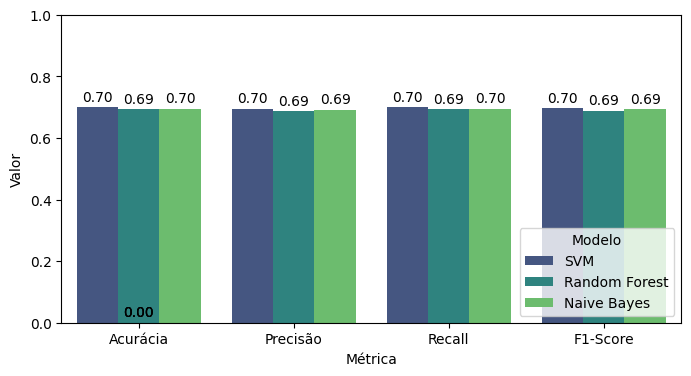

[{'Modelo': 'SVM', 'Acuracia': 0.6992951271835735, 'Precisao': 0.6950723083976752, 'Recall': 0.6992951271835735, 'F1-Score': 0.6966128776694064, 'Matriz': array([[ 8997,  3118,  4200],
       [ 2324, 13500,   491],
       [ 3804,   781, 11730]]), 'Distribuicao': Counter({1: 17399, 2: 16421, 0: 15125})}, {'Modelo': 'Random Forest', 'Acuracia': 0.6934314025947492, 'Precisao': 0.6877438578728453, 'Recall': 0.6934314025947492, 'F1-Score': 0.6890244426216949, 'Matriz': array([[ 8698,  3470,  4147],
       [ 2053, 13790,   472],
       [ 3795,  1068, 11452]]), 'Distribuicao': Counter({1: 18328, 2: 16071, 0: 14546})}, {'Modelo': 'Naive Bayes', 'Acuracia': 0.6951067524772705, 'Precisao': 0.6916980941230036, 'Recall': 0.6951067524772705, 'F1-Score': 0.6930166004504807, 'Matriz': array([[ 8903,  3025,  4387],
       [ 2877, 13149,   289],
       [ 3532,   813, 11970]]), 'Distribuicao': Counter({1: 16987, 2: 16646, 0: 15312})}]


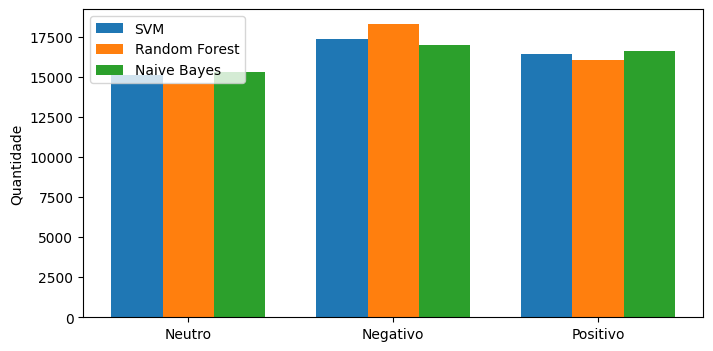

[{'Modelo': 'SVM', 'Acuracia': 0.6992951271835735, 'Precisao': 0.6950723083976752, 'Recall': 0.6992951271835735, 'F1-Score': 0.6966128776694064, 'Matriz': array([[ 8997,  3118,  4200],
       [ 2324, 13500,   491],
       [ 3804,   781, 11730]]), 'Distribuicao': Counter({1: 17399, 2: 16421, 0: 15125})}, {'Modelo': 'Random Forest', 'Acuracia': 0.6934314025947492, 'Precisao': 0.6877438578728453, 'Recall': 0.6934314025947492, 'F1-Score': 0.6890244426216949, 'Matriz': array([[ 8698,  3470,  4147],
       [ 2053, 13790,   472],
       [ 3795,  1068, 11452]]), 'Distribuicao': Counter({1: 18328, 2: 16071, 0: 14546})}, {'Modelo': 'Naive Bayes', 'Acuracia': 0.6951067524772705, 'Precisao': 0.6916980941230036, 'Recall': 0.6951067524772705, 'F1-Score': 0.6930166004504807, 'Matriz': array([[ 8903,  3025,  4387],
       [ 2877, 13149,   289],
       [ 3532,   813, 11970]]), 'Distribuicao': Counter({1: 16987, 2: 16646, 0: 15312})}]
SVM
[[ 8997  3118  4200]
 [ 2324 13500   491]
 [ 3804   781 11730]]


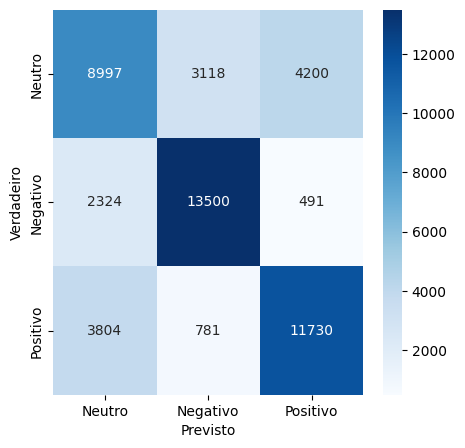

Random Forest
[[ 8698  3470  4147]
 [ 2053 13790   472]
 [ 3795  1068 11452]]


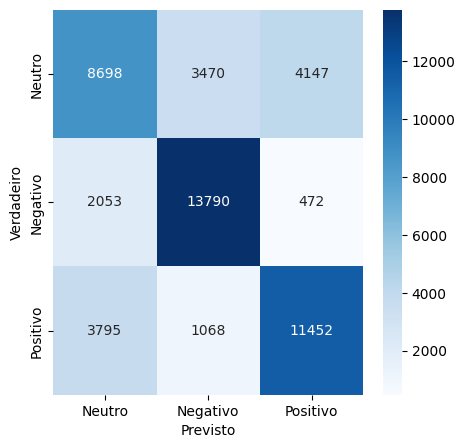

Naive Bayes
[[ 8903  3025  4387]
 [ 2877 13149   289]
 [ 3532   813 11970]]


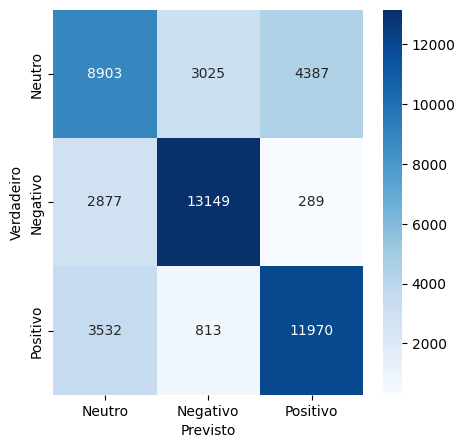

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from collections import Counter

class AnaliseMachineLearning:
    def __init__(self, comentarios_preprocessados, sentimentos):
        self.comentarios_preprocessados = comentarios_preprocessados
        self.sentimentos = sentimentos
        self.resultados = []  # 🔸 armazenar métricas para gráficos

    def randomForest(self, tipoVetor):
        self._validacao_cruzada(RandomForestClassifier(n_estimators=100, random_state=42),
                                tipoVetor, "Random Forest")

    def svm(self, tipoVetor):
        self._validacao_cruzada(LinearSVC(random_state=42),
                                tipoVetor, "SVM")

    def naiveBayes(self, tipoVetor):
        self._validacao_cruzada(MultinomialNB(),
                                tipoVetor, "Naive Bayes")

    def _validacao_cruzada(self, modelo, tipoVetor, nome_modelo):
        vetor = self._vetorizacao(tipoVetor)
        X_vec = vetor.fit_transform(self.comentarios_preprocessados)
        y = np.array(self.sentimentos)

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        acuracias, precisao, recall, f1, distrib_final = [], [], [], [], Counter()

        print(f"\n=== Validação Cruzada (5-Fold) — {nome_modelo} ===")

        # matriz de confusão acumulada
        matriz_total = np.zeros((3, 3), dtype=int)

        for fold, (train_idx, test_idx) in enumerate(kf.split(X_vec), start=1):
            X_train, X_test = X_vec[train_idx], X_vec[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)

            # métricas
            acuracias.append(accuracy_score(y_test, y_pred))
            precisao.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
            recall.append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
            f1.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))

            matriz_total += confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
            distrib_final += Counter(y_pred)

            print(f"\nFold {fold} - {nome_modelo}")
            print(f"Acurácia: {acuracias[-1]:.4f}")

        # 🔸 salvar resultado para gráficos
        self.resultados.append({
            'Modelo': nome_modelo,
            'Acuracia': np.mean(acuracias),
            'Precisao': np.mean(precisao),
            'Recall': np.mean(recall),
            'F1-Score': np.mean(f1),
            'Matriz': matriz_total,
            'Distribuicao': distrib_final
        })

    def _vetorizacao(self, tipo):
        if tipo == 0:
            return TfidfVectorizer(stop_words=list(stopwords), ngram_range=(1,2), max_features=5000) #top_words=list(stopwords)
        elif tipo == 1:
           return TfidfVectorizer(stop_words=list(stopwords),ngram_range=(1, 2), max_features=5000)
        else:
            raise ValueError("Tipo de vetorização inválido. Use 0, 1, 2 ou 3.")

# ============================
# 🧪 Exemplo de uso
# ============================
analise = AnaliseMachineLearning([" ".join(tokens) for tokens in tokens_comentariosss], df['sentimento'])
analise.svm(0)
analise.randomForest(0)
analise.naiveBayes(0)

# ============================
# 📊 Gráficos de Métricas
# ============================

df_metricas = pd.DataFrame([{
    'Modelo': r['Modelo'],
    'Acurácia': r['Acuracia'],
    'Precisão': r['Precisao'],
    'Recall': r['Recall'],
    'F1-Score': r['F1-Score']
} for r in analise.resultados])
print(df_metricas)
df_metricas_melt = df_metricas.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

plt.figure(figsize=(8,4))
sns.barplot(data=df_metricas_melt, x='Métrica', y='Valor', hue='Modelo', palette='viridis')
plt.ylim(0, 1)
plt.legend(title='Modelo')
for bar in plt.gca().patches:
    plt.gca().text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.02,
        f"{bar.get_height():.2f}",
        ha='center'
    )
plt.show()



# ============================
# 📊 Gráfico de Distribuição de Sentimentos
# ============================
plt.figure(figsize=(8,4))
largura = 0.25
classes = ['Neutro', 'Negativo', 'Positivo']
print(analise.resultados)
for i, r in enumerate(analise.resultados):
    dist = r['Distribuicao']
    valores = [dist.get(0,0), dist.get(1,0), dist.get(2,0)]
    pos = [x + i*largura for x in range(len(classes))]
    plt.bar(pos, valores, width=largura, label=r['Modelo'])

plt.xticks([r + largura for r in range(len(classes))], classes)
plt.ylabel('Quantidade')
plt.legend()
plt.show()

# ============================
# 📊 Matriz de Confusão para cada Modelo
# ============================

print(analise.resultados)
for r in analise.resultados:
    print(r['Modelo'])
    print(r['Matriz'])
    plt.figure(figsize=(5,5))
    sns.heatmap(r['Matriz'], annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.show()
